## Anomaly Detection Toolkit (ADTK)

- unsupervised/rule-based models of time series anomaly detection
- works with Pandas 1.5.3
- data in this example: list (11 profiles, but not original data was used: Difference between daily average and individual profile was calculated) 

In [13]:
# import the necessary libraries
import pandas as pd
from adtk.data import validate_series
from adtk.detector import PersistAD
from adtk.visualization import plot
from adtk.transformer import DoubleRollingAggregate
from adtk.pipe import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from adtk.detector import InterQuartileRangeAD

#### loading data

In [14]:
combined_df = pd.read_csv('diff_df.csv', index_col=0)
combined_df.index.name = 'time'
combined_df.index = pd.to_datetime(combined_df.index)
combined_df = validate_series(combined_df)

<Axes: xlabel='time'>

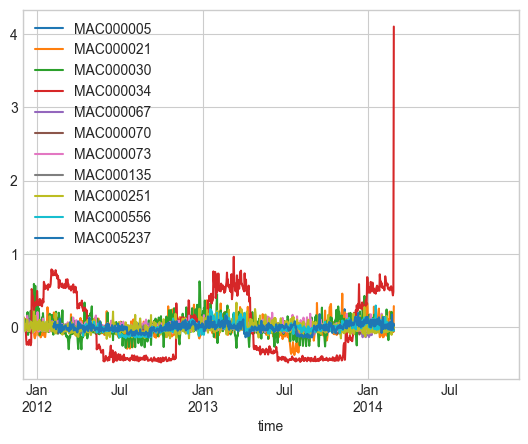

In [15]:
# calculate the daily average of all time points and plot
daily_ave = combined_df.resample('D').mean()
daily_ave.plot()

## Outlier detection

### Interquartile Range
-compares time series values with 1st and 3rd quartiles of historical data, and identifies time points as anomalous when differences are beyond the inter-quartile range (IQR) times a user-given factor c

In [16]:
# calculate interquartile range
iqr_ad = InterQuartileRangeAD(c=10)
anomalies = iqr_ad.fit_detect(combined_df)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

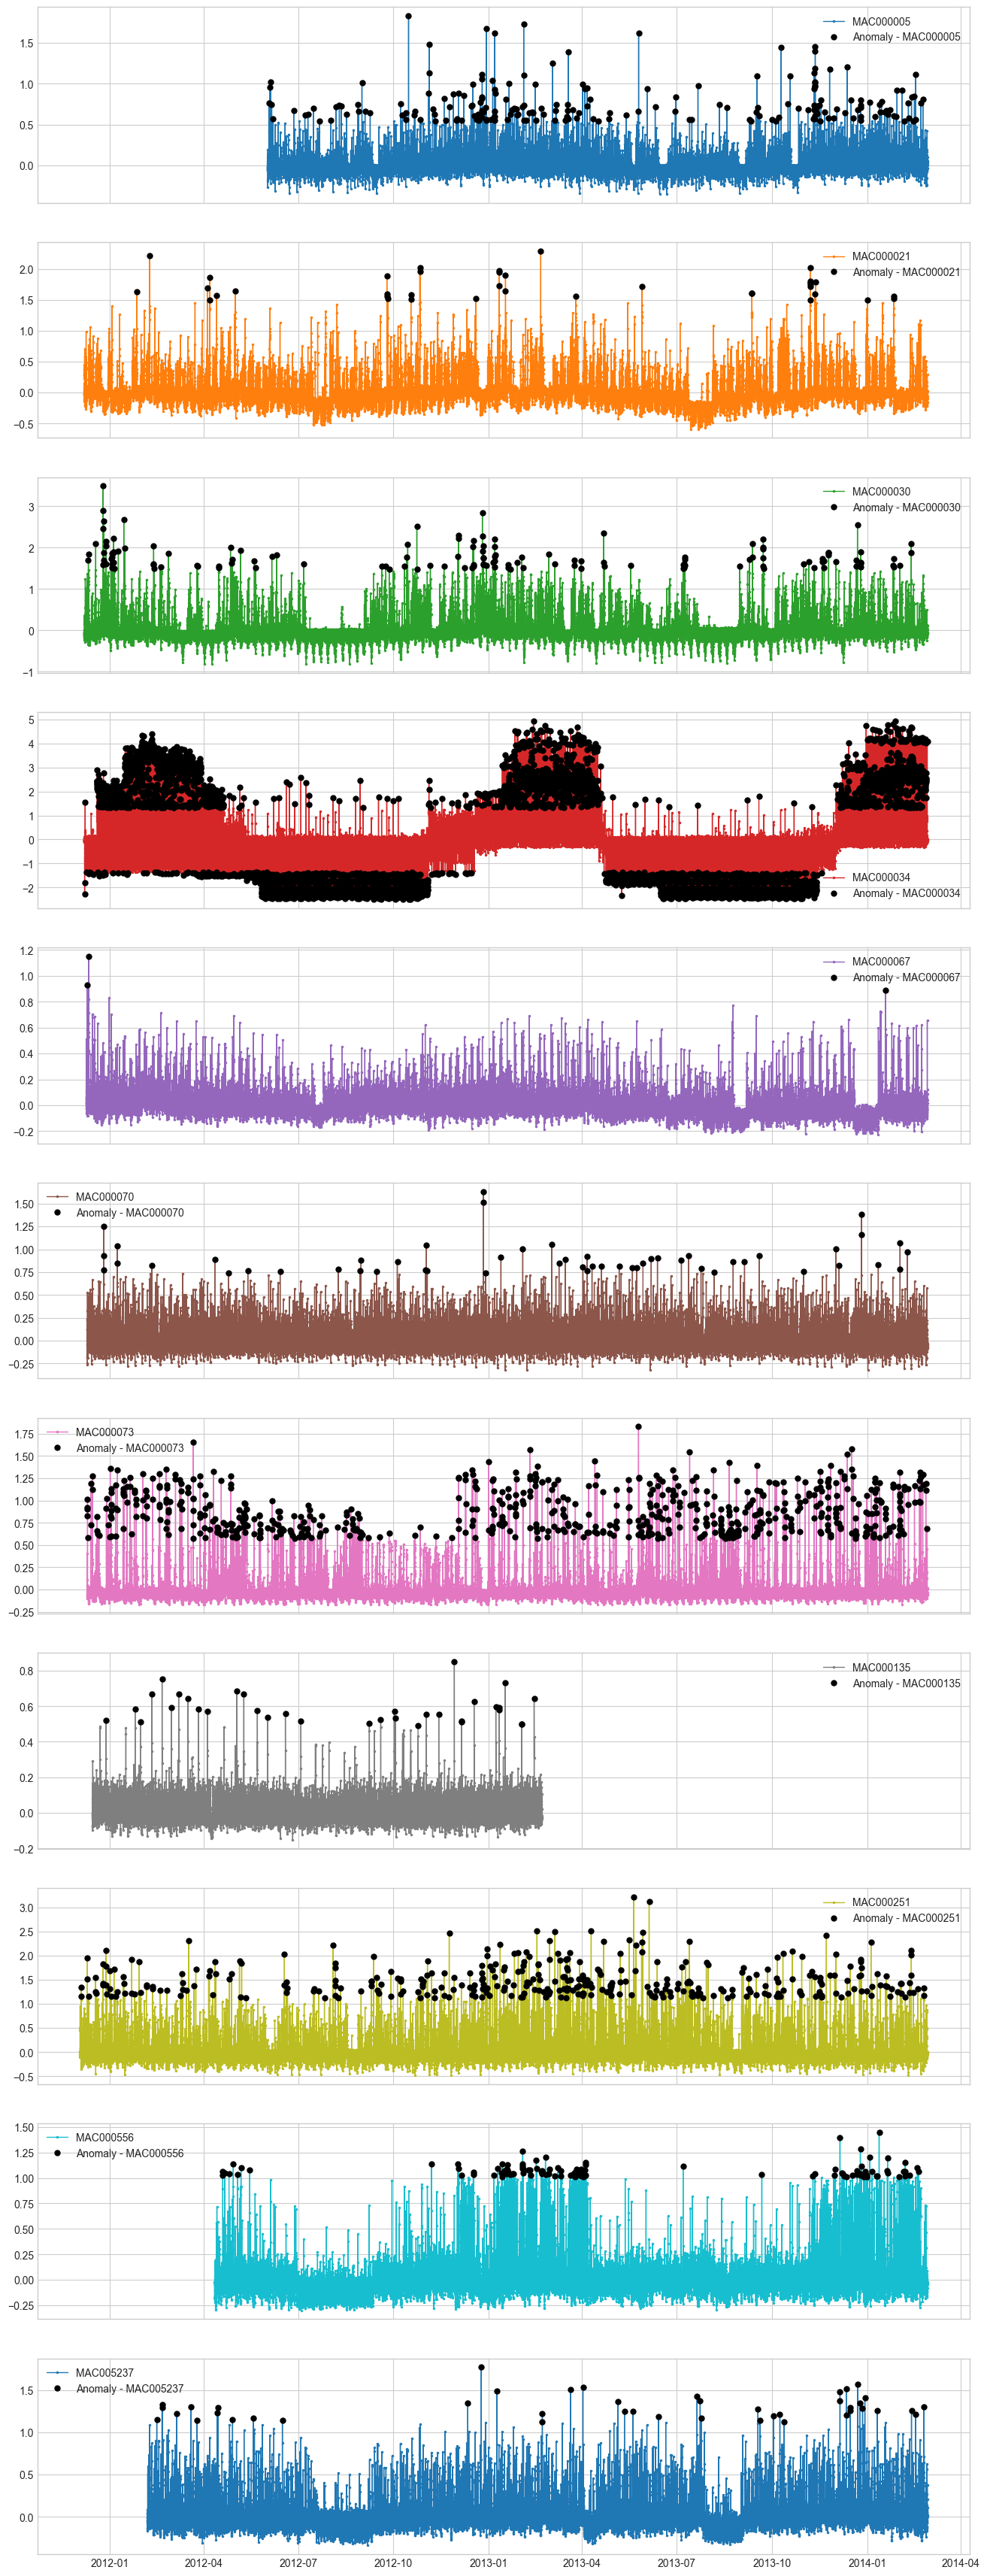

In [17]:
# plot the anomalies along with the original data
plot(combined_df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color= 'black', anomaly_tag="marker")

## Spike Detection

- combined transformer "double rolling aggregate" with detector "persist"

### double rolling aggregate
- transformer, rolls two sliding windows side-by-side along a time series, aggregates using a selected operation, and tracks difference of the aggregated metrics between the two windows

In [18]:
# transform data with double rolling aggregate (median is used in this case)
df_transformedDRA = DoubleRollingAggregate(
    agg="median",
    window='10 D',
    diff="l2").transform(combined_df) #diff: difference method applied between aggregated metrics from the sliding windows l2: square root of sum of elementwise squared difference

Text(0.5, 1.0, 'Double Rolling Aggregate, window size: 10 days, median')

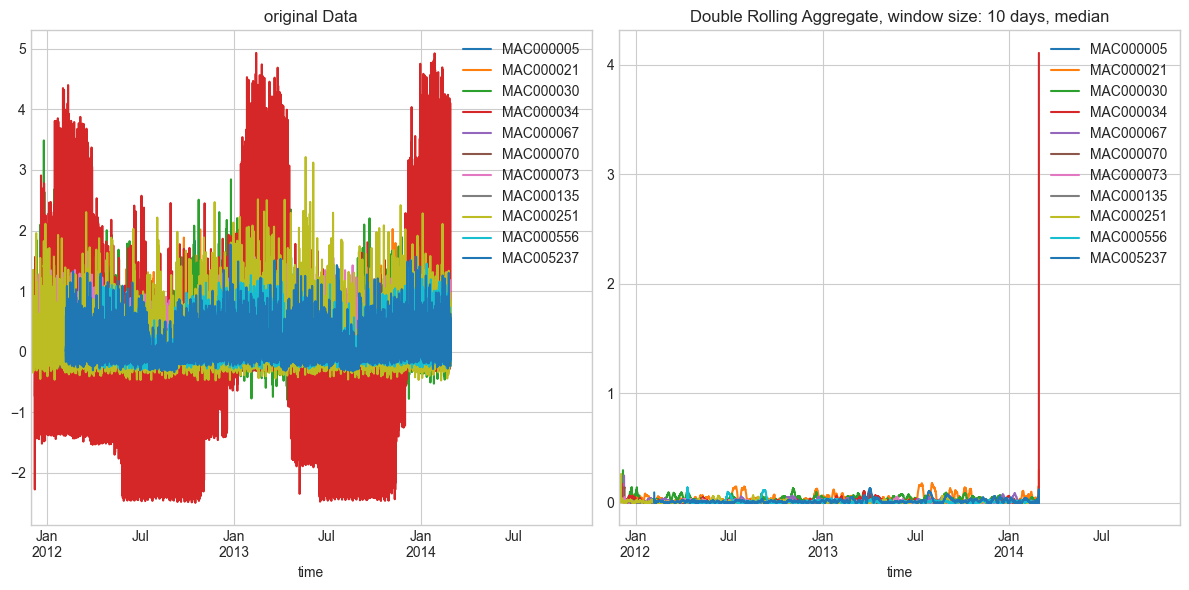

In [19]:
# plot the original and transformed data in comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6), tight_layout=False, sharex=False, sharey=False)

combined_df.plot(ax=axes[0])
axes[0].set_title('original Data')

df_transformedDRA.plot(ax=axes[1])
axes[1].set_title('Double Rolling Aggregate, window size: 10 days, median')

### Persist AD

- detector compares time series values with the values of their preceding time windows, internally implemented as a Pipenet object
- recommended for detecting spikes in time series

C:\Users\Anka\NeuerOrdner\envs\ADTKoldPandas\Lib\site-packages\adtk\data\_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

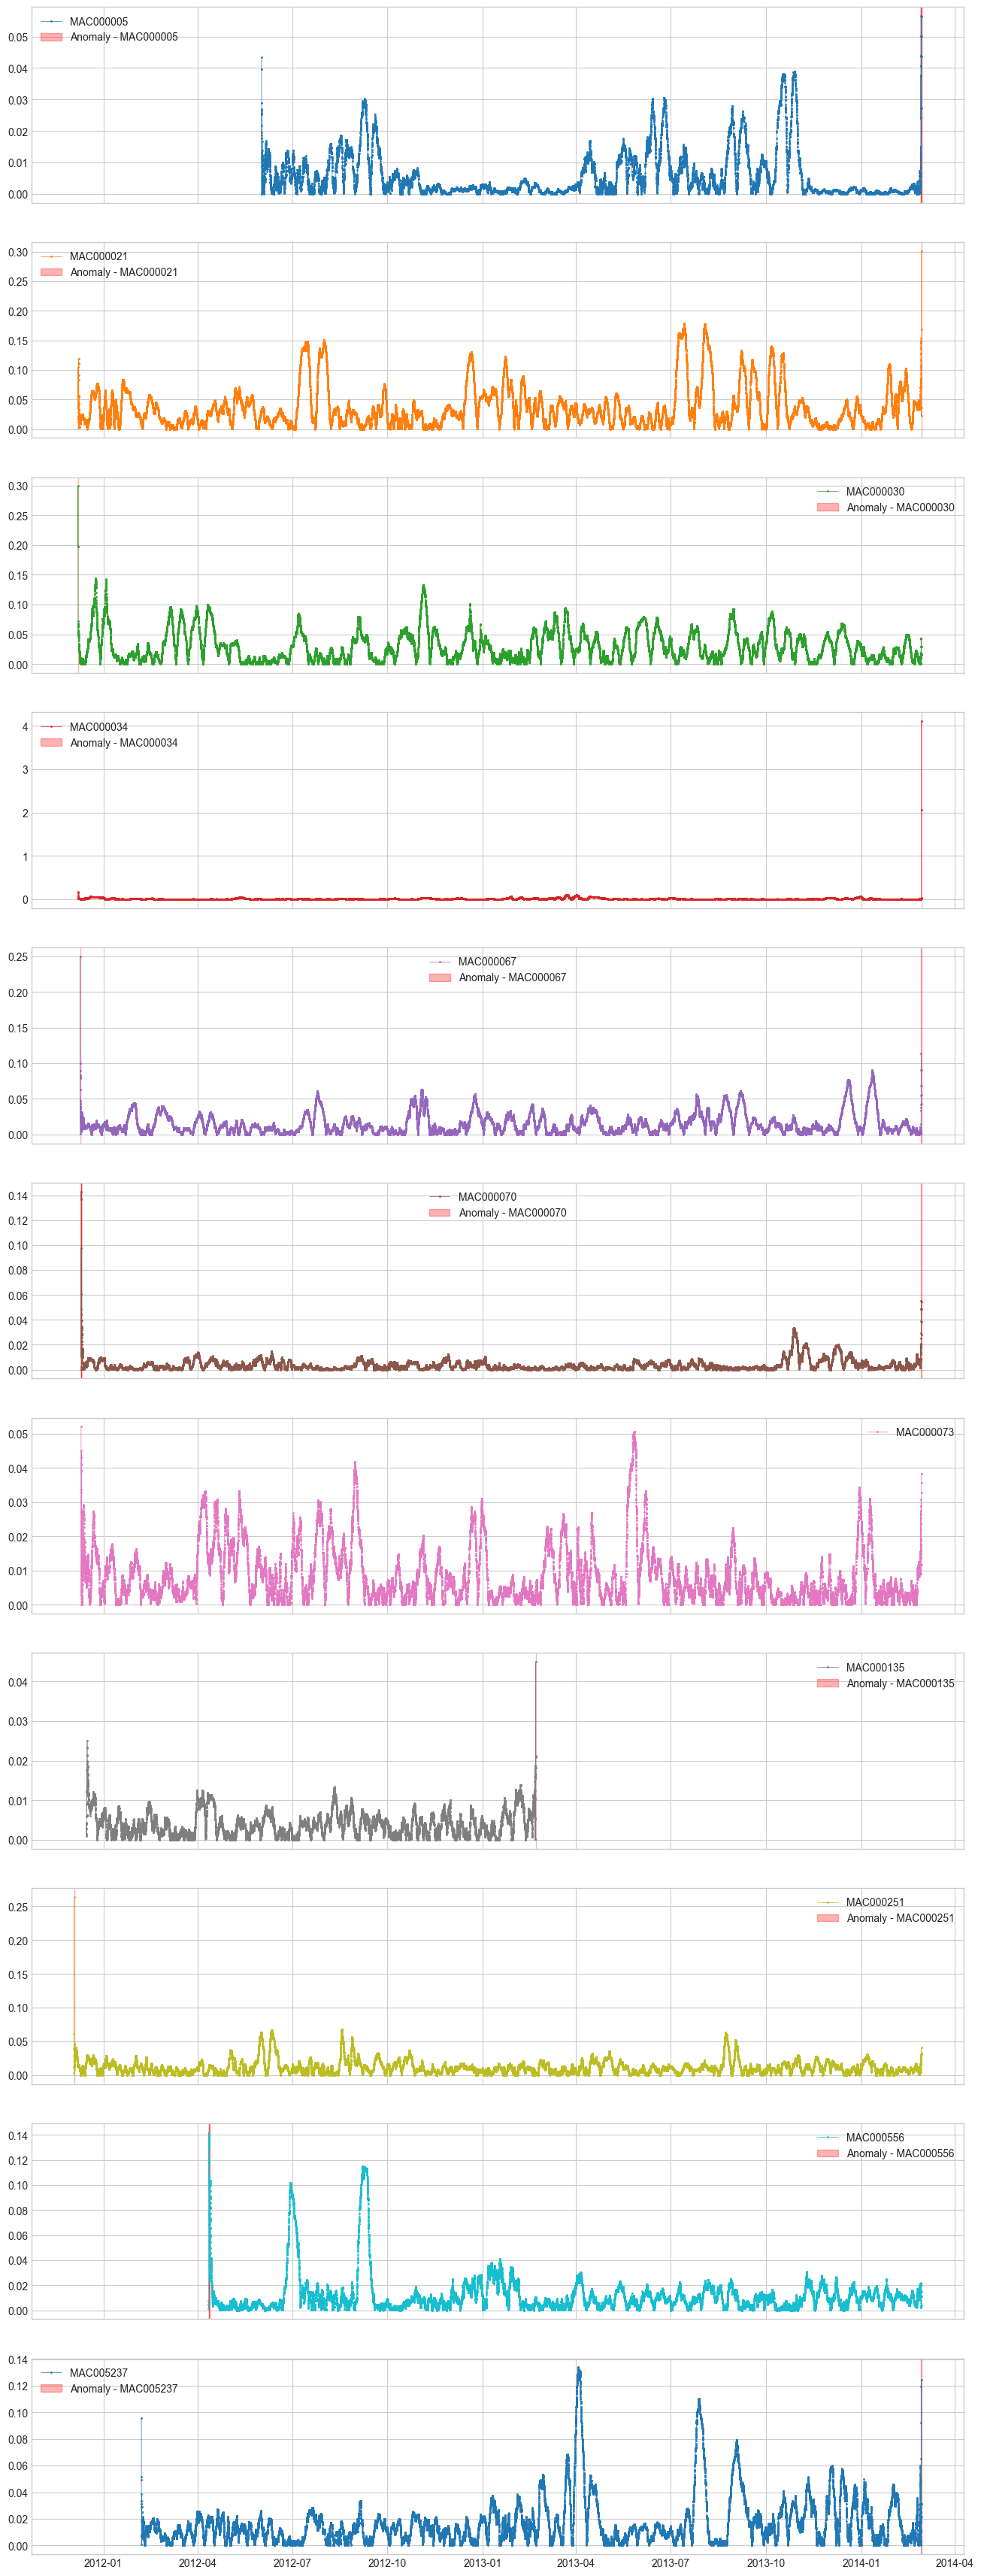

In [20]:
# 
persist_ad = PersistAD(c=20.0, side='both', window='D')
anomalies = persist_ad.fit_detect(df_transformedDRA, return_list=True)

plot(df_transformedDRA, anomaly=anomalies, anomaly_color='red')

In [21]:
#Anomaly labels added to the original df for further analysis

# Create an empty DataFrame with the same index and columns as df_transformedDRA
outliers_df = pd.DataFrame(index=df_transformedDRA.index, columns=df_transformedDRA.columns)

# Loop through each column and mark outliers as "1" and non-outliers as "0"
for col in df_transformedDRA.columns:
    outliers_col = []
    for idx, row in df_transformedDRA.iterrows():
        is_outlier = any(start <= idx <= end for start, end in anomalies.get(col, []))
        outliers_col.append(1 if is_outlier else 0)
    outliers_df[col + "_outliers"] = outliers_col

# Merge the outliers DataFrame with the original DataFrame
merged_df = pd.concat([df_transformedDRA, outliers_df], axis=1)

#print(filtered_df)

# Filter rows where any outlier column contains a value of "1"
filtered_df = merged_df[merged_df.filter(like='_outliers').any(axis=1)]

print(filtered_df)

                     MAC000005  MAC000021  MAC000030  MAC000034  MAC000067  \
time                                                                         
2011-12-03 16:00:00        NaN        NaN        NaN        NaN        NaN   
2011-12-07 13:30:00        NaN   0.039317   0.072559   0.174662        NaN   
2011-12-07 14:00:00        NaN   0.042150   0.046860   0.132940        NaN   
2011-12-07 14:30:00        NaN   0.039317   0.049339   0.091045        NaN   
2011-12-09 13:00:00        NaN   0.009147   0.009622   0.007554   0.249766   
2011-12-10 11:00:00        NaN   0.017474   0.004306   0.001651   0.005289   
2011-12-10 11:30:00        NaN   0.016276   0.005925   0.000802   0.005155   
2011-12-10 12:00:00        NaN   0.017759   0.004142   0.001978   0.005142   
2011-12-10 12:30:00        NaN   0.018557   0.005761   0.002991   0.005128   
2011-12-10 13:00:00        NaN   0.019450   0.004142   0.003605   0.005732   
2011-12-10 15:00:00        NaN   0.019661   0.002113   0.006552 

### original data, transformed data, anomalies in one plot
- the cells below essentially contain the same functions (double rolling aggregate + persist) as before, work arround to be able to visualize original data, double rolling aggregate transform and anomaly in the same plot

In [22]:
combined_df = combined_df.apply(validate_series)

# Define the first step without the detection part
rolling_avg_step = DoubleRollingAggregate(agg='median', window='10D')

# Define the detection step separately
detection_step = PersistAD(c=20.0, side='both', window='D')

# Combine the steps into the pipeline without the detection step
steps_without_detection = [("Double Rolling Average", rolling_avg_step)]
myPipeline_without_detection = Pipeline(steps_without_detection)

# Add the detection step back to the pipeline
steps_with_detection = steps_without_detection + [('PersistAD', detection_step)]

# Create the pipeline with the detection step
myPipeline_with_detection = Pipeline(steps_with_detection)

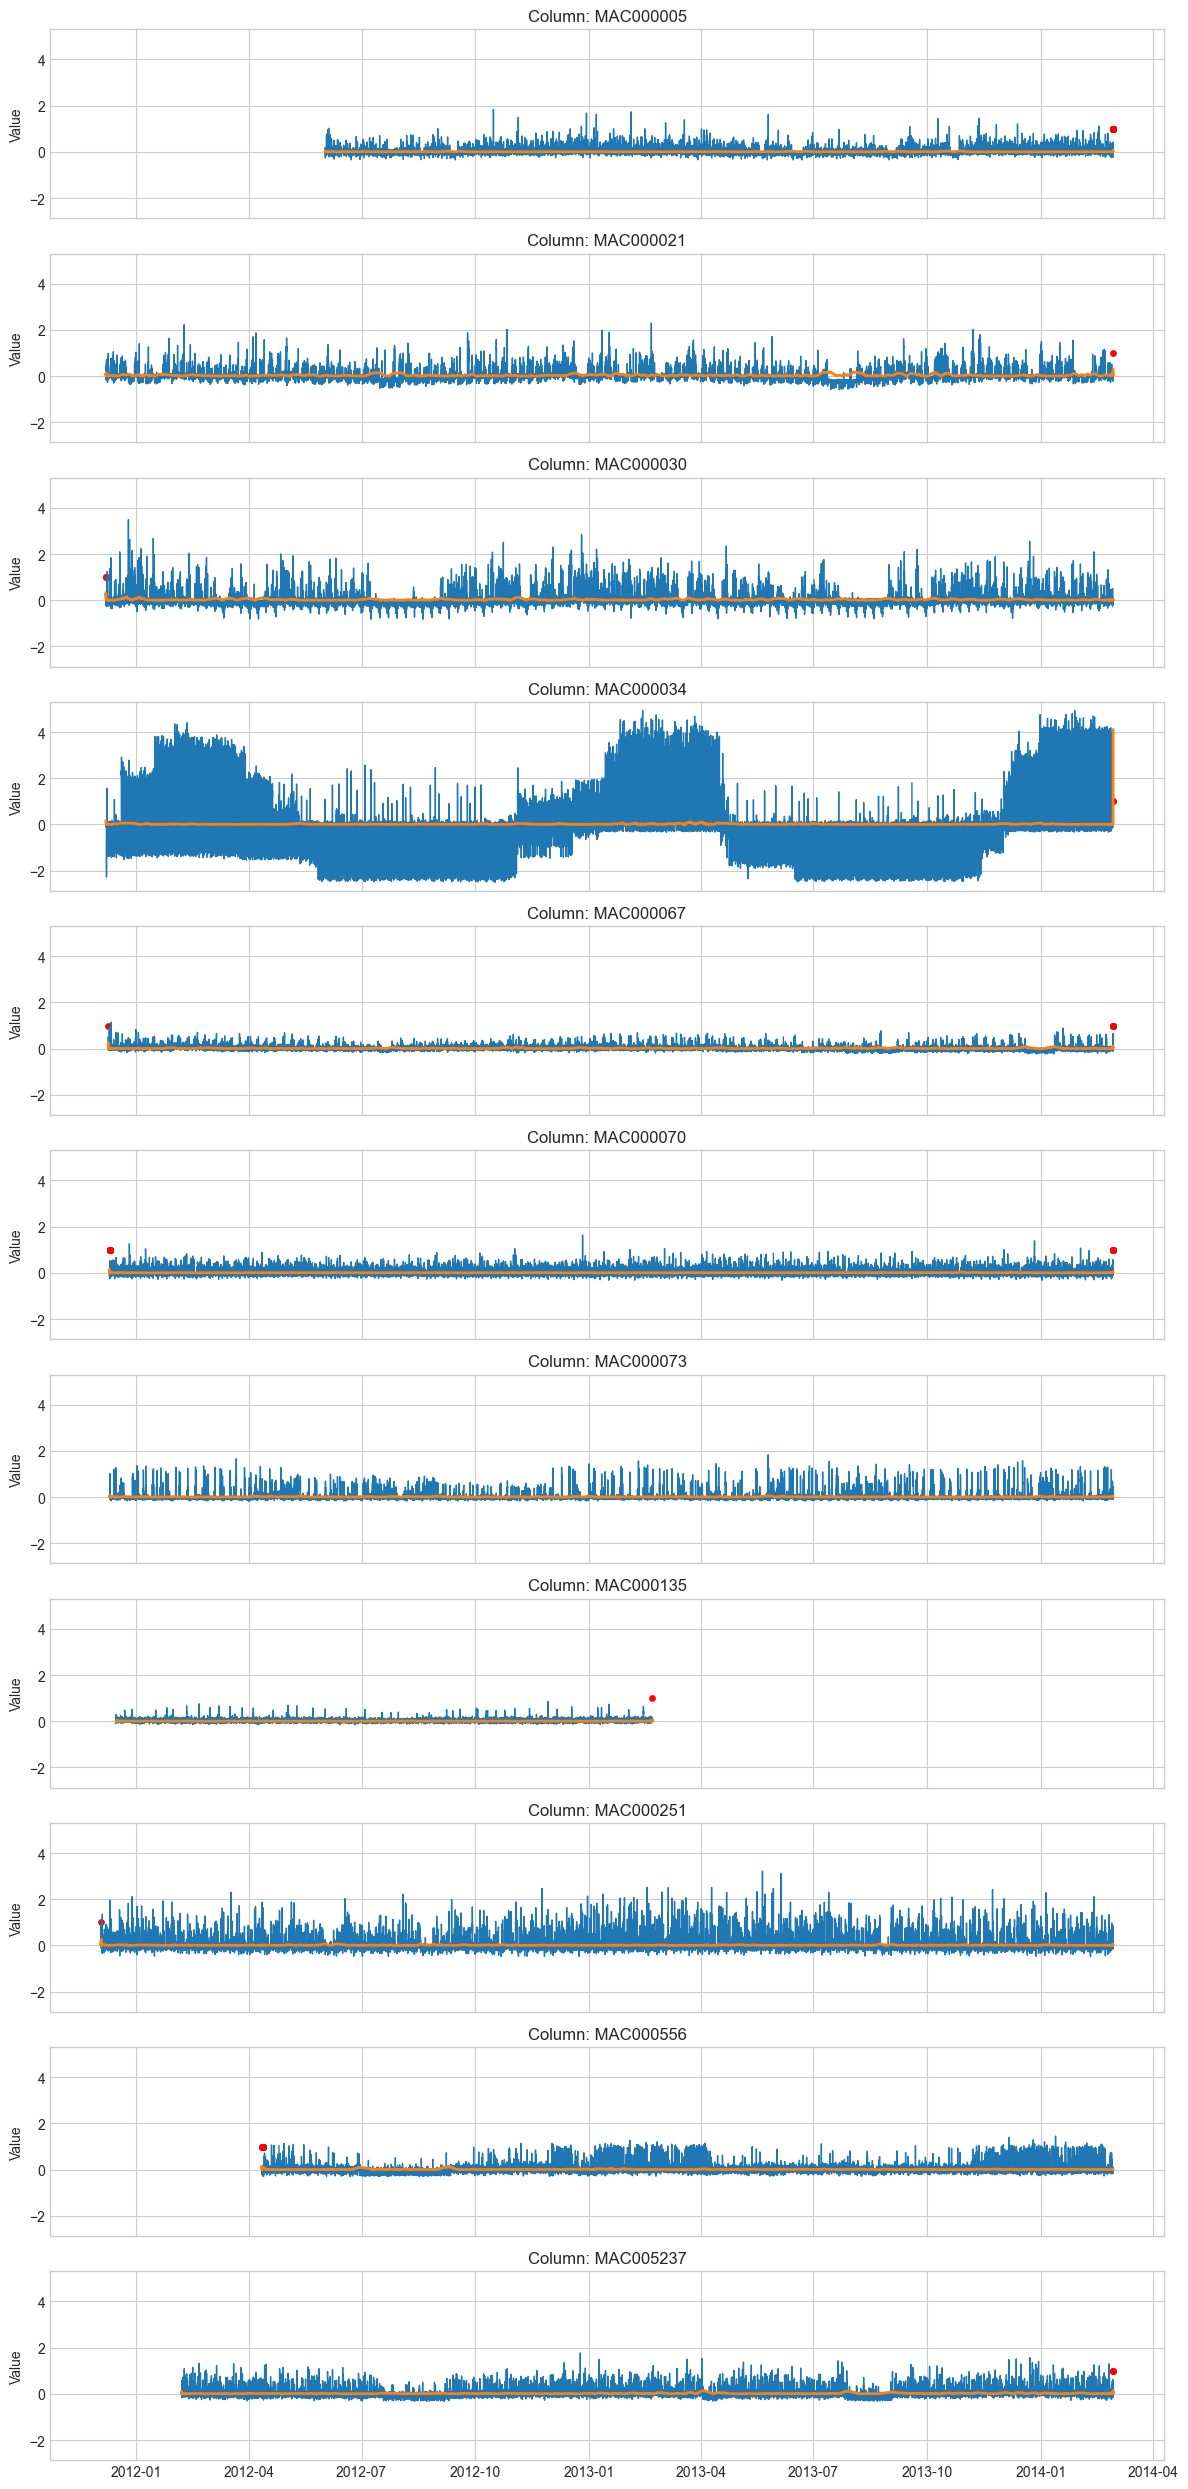

In [23]:
# Create a separate subplot for each column in the DataFrame
num_columns = len(combined_df.columns)
fig, axs = plt.subplots(num_columns, 1, figsize=(12, 25), sharex=True, sharey=True)

# Loop through each column and plot the original data, double rolling average, and detected anomalies
for i, column in enumerate(combined_df.columns):
    # Get the time series data for the current column
    column_data = combined_df[column]

    # Apply the first step on the data
    transformed_series = myPipeline_without_detection.fit_transform(column_data)

    # Detect anomalies in the data using the pipeline with the detection step
    anomalies = myPipeline_with_detection.fit_detect(column_data)

    # Filter the anomalies to retain only the detected anomaly values, set non-anomaly values to NaN
    anomalies[anomalies == 0] = np.nan

    # Plot the original data in the current subplot
    axs[i].plot(column_data.index, column_data.values, label='Original', linewidth=1)

    # Plot the detected anomalies in the current subplot (using scatter instead of plot)
    axs[i].scatter(anomalies.index, anomalies, c='red', marker='o', s=15, label='Anomalies')

    # Plot the double rolling average in the current subplot
    axs[i].plot(transformed_series.index, transformed_series.values, label='Double Rolling Average', linewidth=2)

    # Set subplot title and labels
    axs[i].set_title(f'Column: {column}')
    axs[i].set_ylabel('Value')

# Adjust the layout and spacing between subplots
plt.tight_layout()

plt.show()

In [ ]:
import warnings

# Filter out the FutureWarning related to iteritems
warnings.filterwarnings('ignore', category=FutureWarning, message='.*iteritems is deprecated.*')

## Level Shift

-detects shift of value level by tracking the difference between median values at two sliding time windows next to each other

In [12]:
# determine level shifts
level_shift_ad = LevelShiftAD(c=2, side='both', window='5D') #Factor used to determine bound of normal range based on historical interquartile range
anomalies = level_shift_ad.fit_detect(df, return_list=True)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

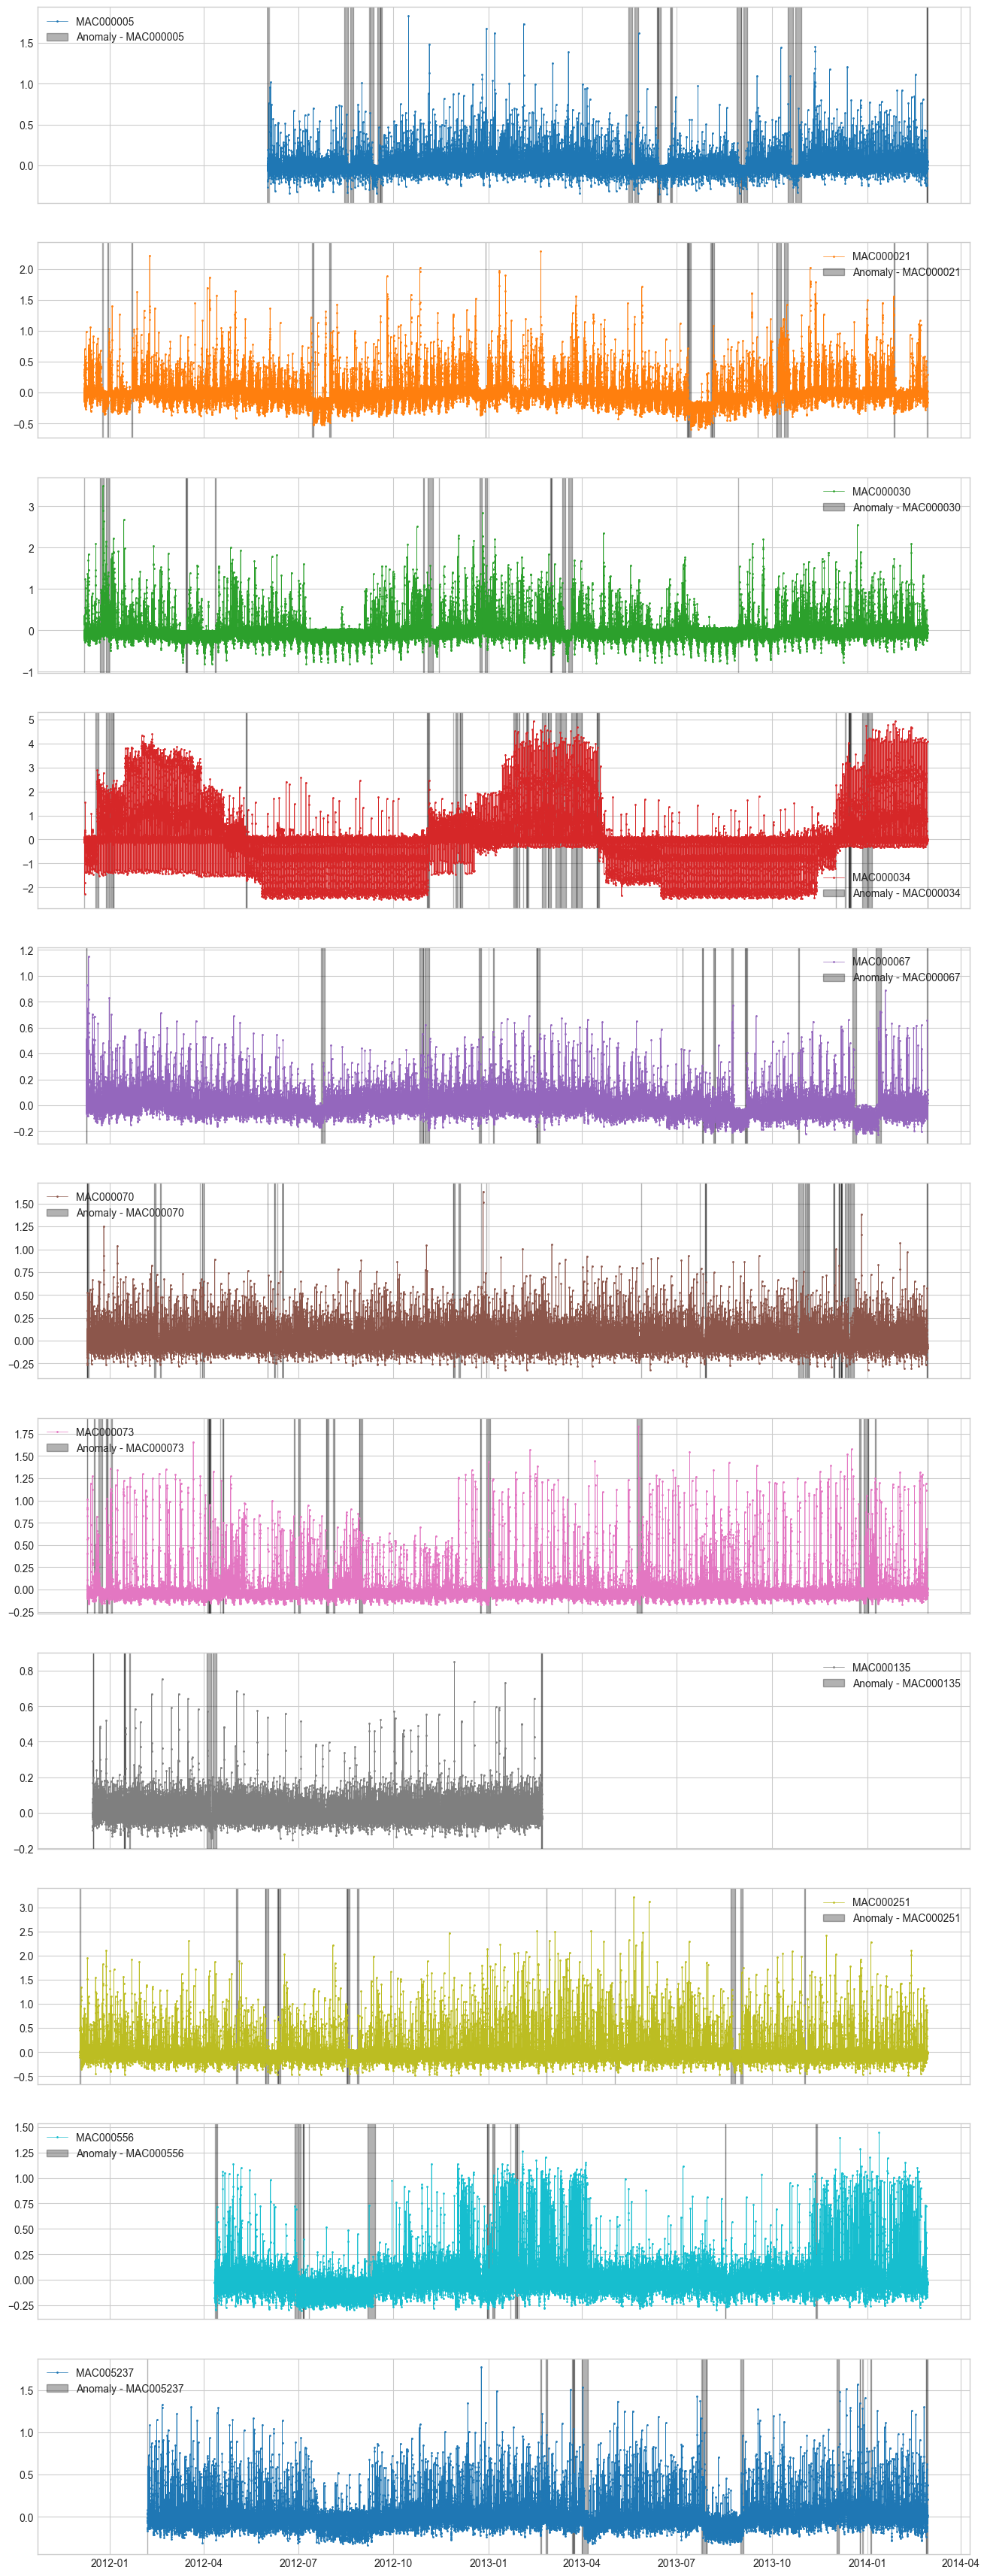

In [13]:
# plot level shift anomalies
plot(df, anomaly=anomalies, anomaly_color='black')

In [14]:
#Anomaly labels added to the original df for further analysis

# Create an empty DataFrame with the same index and columns as df_transformedDRA
outliers_df = pd.DataFrame(index=df.index, columns=df.columns)

# Loop through each column and mark outliers as "1" and non-outliers as "0"
for col in df.columns:
    outliers_col = []
    for idx, row in df.iterrows():
        is_outlier = any(start <= idx <= end for start, end in anomalies.get(col, []))
        outliers_col.append(1 if is_outlier else 0)
    outliers_df[col + "_outliers"] = outliers_col

# Merge the outliers DataFrame with the original DataFrame
merged_df = pd.concat([df, outliers_df], axis=1)

#print(filtered_df)

# Filter rows where any outlier column contains a value of "1"
filtered_df = merged_df[merged_df.filter(like='_outliers').any(axis=1)]

print(filtered_df)

                     MAC000005  MAC000021  MAC000030  MAC000034  MAC000067  \
time                                                                         
2011-12-03 13:00:00        NaN        NaN        NaN        NaN        NaN   
2011-12-03 16:00:00        NaN        NaN        NaN        NaN        NaN   
2011-12-07 12:00:00        NaN  -0.021282   0.355983        NaN        NaN   
2011-12-07 12:30:00        NaN   0.039629  -0.160128        NaN        NaN   
2011-12-07 13:00:00        NaN   0.002222  -0.096162   0.120239        NaN   
...                        ...        ...        ...        ...        ...   
2014-02-27 22:00:00   0.101593  -0.061872  -0.081681  -0.025650   0.655647   
2014-02-27 22:30:00  -0.033868  -0.091724   0.121137  -0.033470   0.120103   
2014-02-27 23:00:00   0.005681  -0.154709   0.024179   0.003241   0.087052   
2014-02-27 23:30:00   0.038714   0.025812  -0.068197   0.019598   0.042348   
2014-02-28 00:00:00   0.051396   0.290419  -0.041863   4.100205 

## Volatility Shift
- detects shift of volatility level by tracking the difference between standard deviations at two sliding time windows next to each other

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

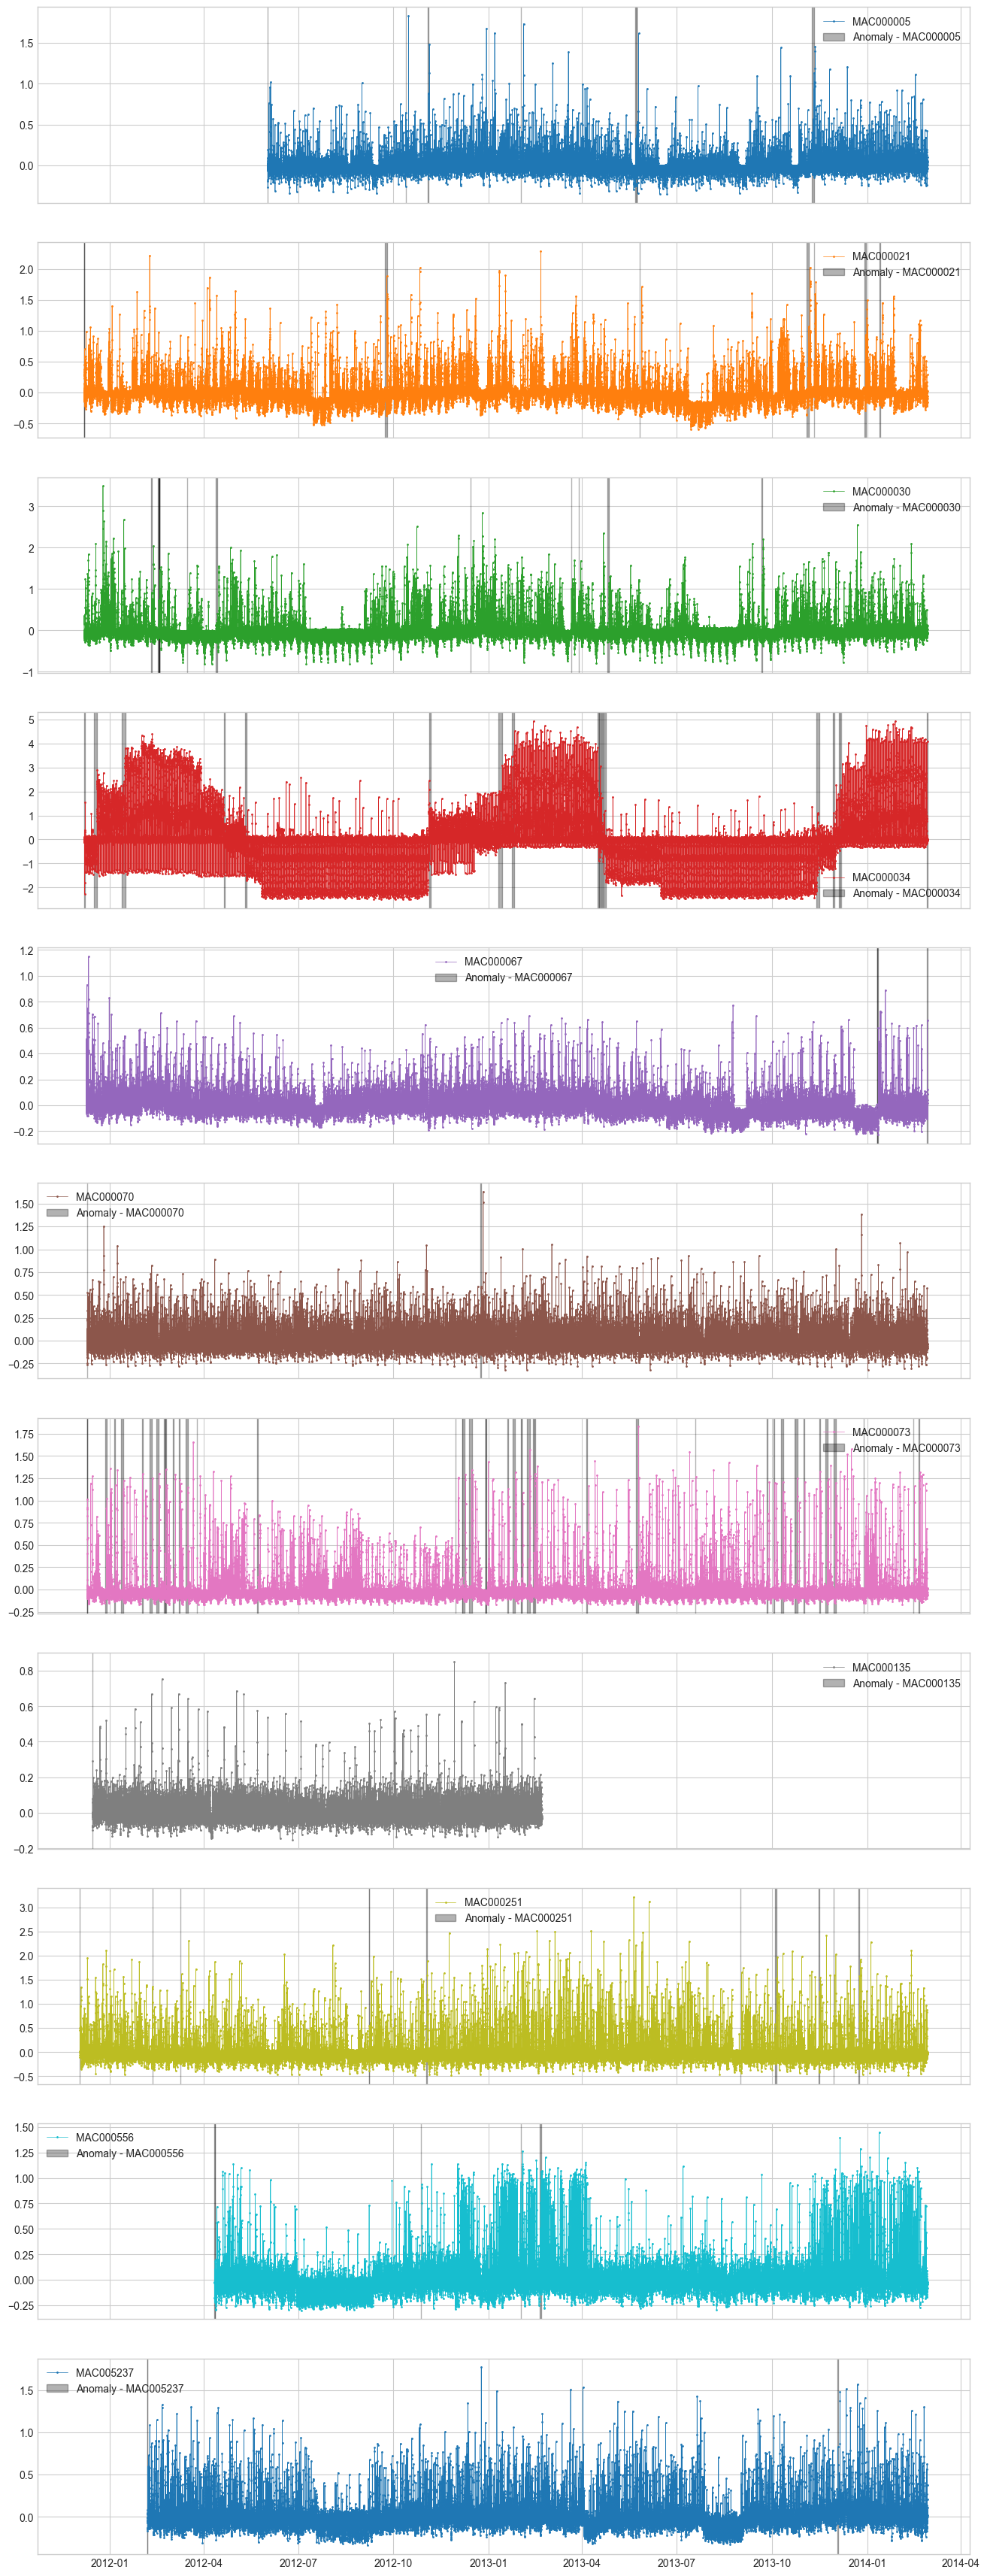

In [7]:
volatility_shift_ad = VolatilityShiftAD(c=5.0, side='both', window='3D')
anomalies = volatility_shift_ad.fit_detect(df, return_list=True)
plot(df, anomaly=anomalies, anomaly_color='black')

In [8]:
#Anomaly labels added to the original df for further analysis

# Create an empty DataFrame with the same index and columns as df_transformedDRA
outliers_df = pd.DataFrame(index=df.index, columns=df.columns)

# Loop through each column and mark outliers as "1" and non-outliers as "0"
for col in df.columns:
    outliers_col = []
    for idx, row in df.iterrows():
        is_outlier = any(start <= idx <= end for start, end in anomalies.get(col, []))
        outliers_col.append(1 if is_outlier else 0)
    outliers_df[col + "_outliers"] = outliers_col

# Merge the outliers DataFrame with the original DataFrame
merged_df = pd.concat([df, outliers_df], axis=1)

#print(filtered_df)

# Filter rows where any outlier column contains a value of "1"
filtered_df = merged_df[merged_df.filter(like='_outliers').any(axis=1)]

print(filtered_df)

                     MAC000005  MAC000021  MAC000030  MAC000034  MAC000067  \
time                                                                         
2011-12-03 13:00:00        NaN        NaN        NaN        NaN        NaN   
2011-12-07 12:30:00        NaN   0.039629  -0.160128        NaN        NaN   
2011-12-07 14:00:00        NaN   0.048701  -0.156855  -0.001684        NaN   
2011-12-07 14:30:00        NaN  -0.037624  -0.107410  -0.039504        NaN   
2011-12-07 15:00:00        NaN   0.029915  -0.083726  -0.036761        NaN   
...                        ...        ...        ...        ...        ...   
2014-02-27 21:30:00  -0.067700  -0.175368  -0.162333   0.013906  -0.083948   
2014-02-27 22:00:00   0.101593  -0.061872  -0.081681  -0.025650   0.655647   
2014-02-27 22:30:00  -0.033868  -0.091724   0.121137  -0.033470   0.120103   
2014-02-27 23:00:00   0.005681  -0.154709   0.024179   0.003241   0.087052   
2014-02-27 23:30:00   0.038714   0.025812  -0.068197   0.019598 